# [Контест](https://www.kaggle.com/competitions/scintillation-detector) на Kaggle

Нам даны данные о 23 479 сигналах с различных набором характеристик этих сигналов. Задача - кластеризовать эти сигналы на три кластера по типу сигналов: первые два кластера отображают типы сигналов (гамма-кванты или нейтроны), третий кластер представляет себя группу сигналов, которые не поддаются кластеризации.

In [897]:
%pip install opendatasets
import opendatasets as od

In [898]:
od.download_kaggle_dataset("https://www.kaggle.com/competitions/scintillation-detector/data", "")

Skipping, found downloaded files in "scintillation-detector" (use force=True to force download)


# Обработка данных

In [899]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

from tqdm import tqdm

In [900]:
dataset = pd.read_csv("scintillation-detector/Run200_Wave_0_1.txt", sep=" ", header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [901]:
dataset = (2**14) - dataset - 1560

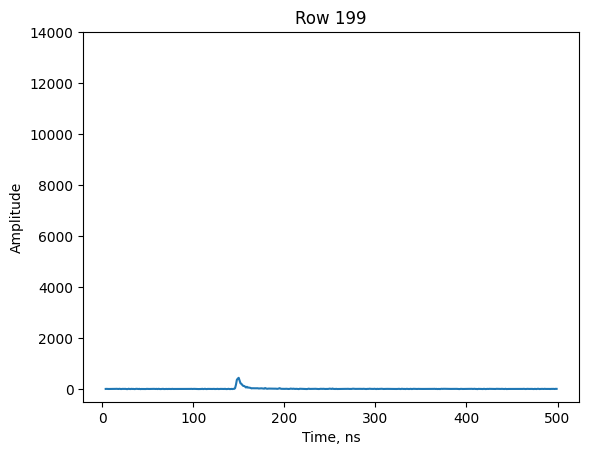

In [902]:
fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    sns.lineplot(data=dataset.iloc[i][4:504], ax=ax)
    ax.set_title(f"Row {i}")
    ax.set_ylim(-500, 14000)
    ax.set_xlabel("Time, ns")
    ax.set_ylabel("Amplitude")

anim = FuncAnimation(fig, animate, frames=range(140, 200), interval=200, repeat=True)
anim.save("lineplot_animation.gif", writer="pillow", fps=5)
plt.show()

In [903]:
amplitudes = []
volumes = []
psd_values = []
for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
    signal = row.values.astype(float)

    signal -= np.mean(signal[:50])
    noise = 3 * np.std(signal[:50])

    max_index = np.argmax(signal)
    end_index = len(signal)
    for i in range(max_index, len(signal)):
        if signal[i] < noise:
            end_index = i
            break

    signal = signal[max_index:end_index]

    amplitudes.append(np.abs(np.max(signal) - np.min(signal)))

    volumes.append(np.trapezoid(signal))

    psd_values.append((volumes[-1] - np.trapezoid(signal[:5])) / volumes[-1])

amplitudes = np.array(amplitudes)
volumes = np.array(volumes)
psd_values = np.array(psd_values)

100%|██████████| 23479/23479 [00:17<00:00, 1370.13it/s]


### Диаграмма рассеивания

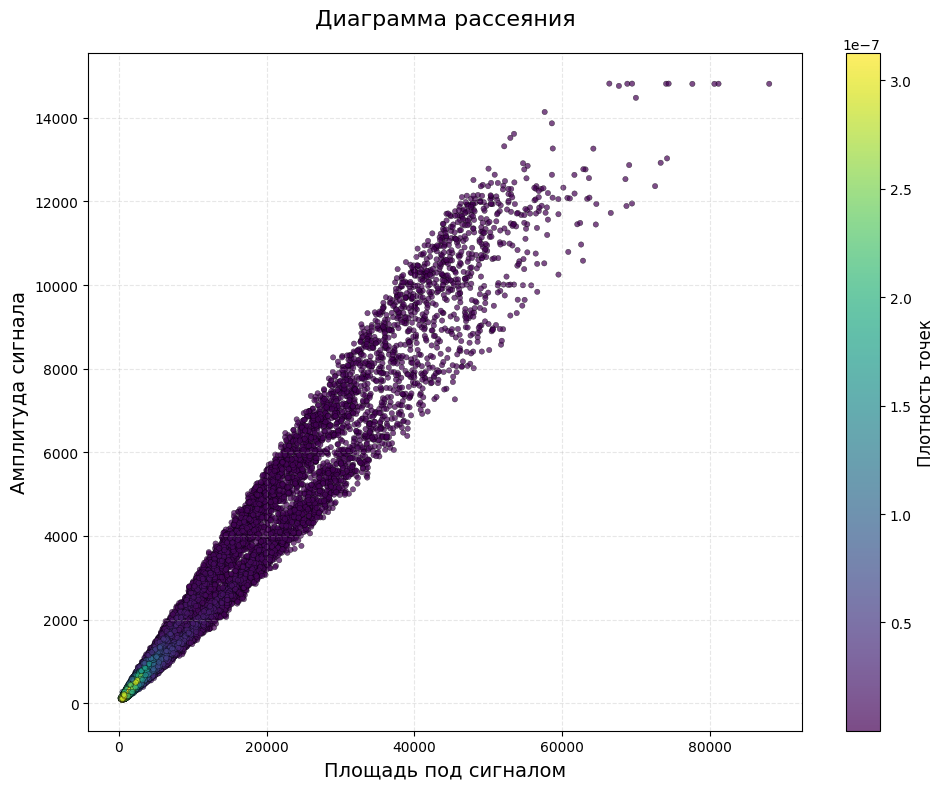

In [904]:
xy = np.vstack([volumes, amplitudes])
density = gaussian_kde(xy)(xy)

plt.figure(figsize=(10, 8))

scatterplot = plt.scatter(volumes, amplitudes,
                          c=density,
                          s=15,
                          alpha=0.7,
                          cmap="viridis",
                          edgecolors="black",
                          linewidths=0.3)

cbar = plt.colorbar(scatterplot)
cbar.set_label("Плотность точек", fontsize=12)

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда сигнала", fontsize=14)
plt.title("Диаграмма рассеяния",
          fontsize=16, pad=20)

plt.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

### PSD диаграмма

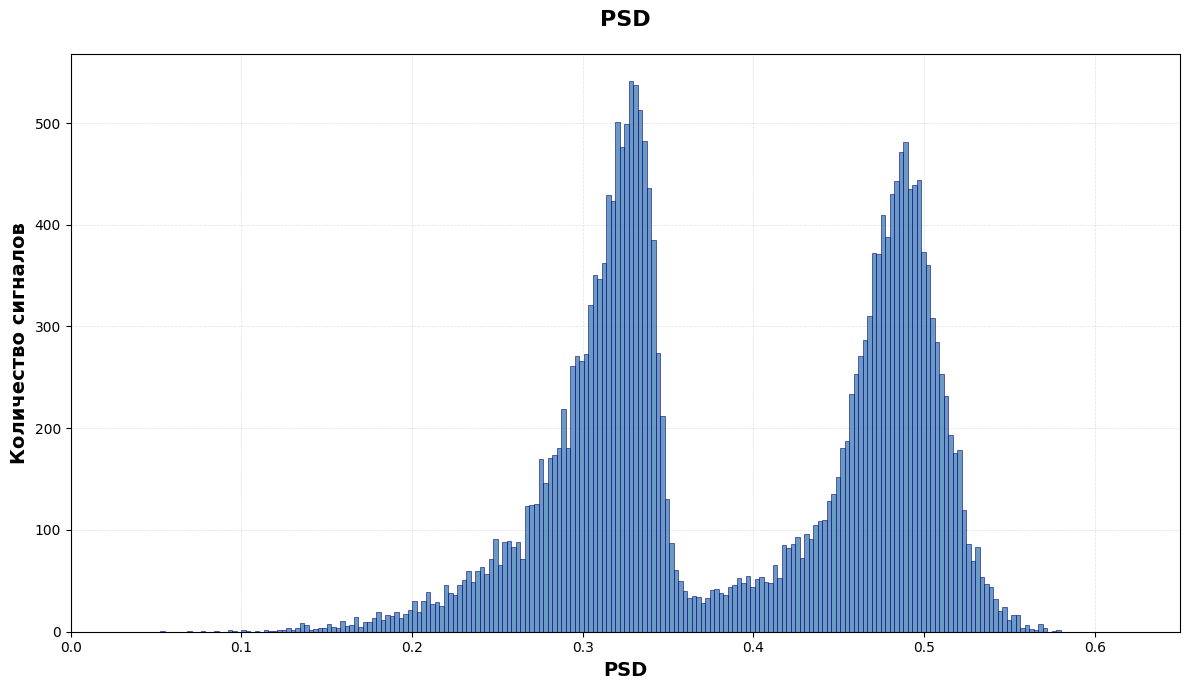

In [905]:
plt.figure(figsize=(12, 7))
plt.hist(psd_values, bins=200, alpha=0.8, color="steelblue", edgecolor="navy", linewidth=0.5)
plt.xlabel("PSD", fontsize=14, fontweight="bold")
plt.xlim(0, 0.65)
plt.ylabel("Количество сигналов", fontsize=14, fontweight="bold")
plt.title("PSD", fontsize=16, fontweight="bold", pad=20)
plt.grid(True, alpha=0.4, linestyle="--", linewidth=0.5)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

# Кластеризация

In [906]:
dataset["amplitude"] = amplitudes
dataset["volume"] = volumes
dataset["psd"] = psd_values

In [907]:
def save(labels):
    pd.DataFrame({
        "index": dataset.index,
        "cluster": labels
    }).sort_values(by="cluster", kind="stable").to_csv("clusters.csv", index=False)

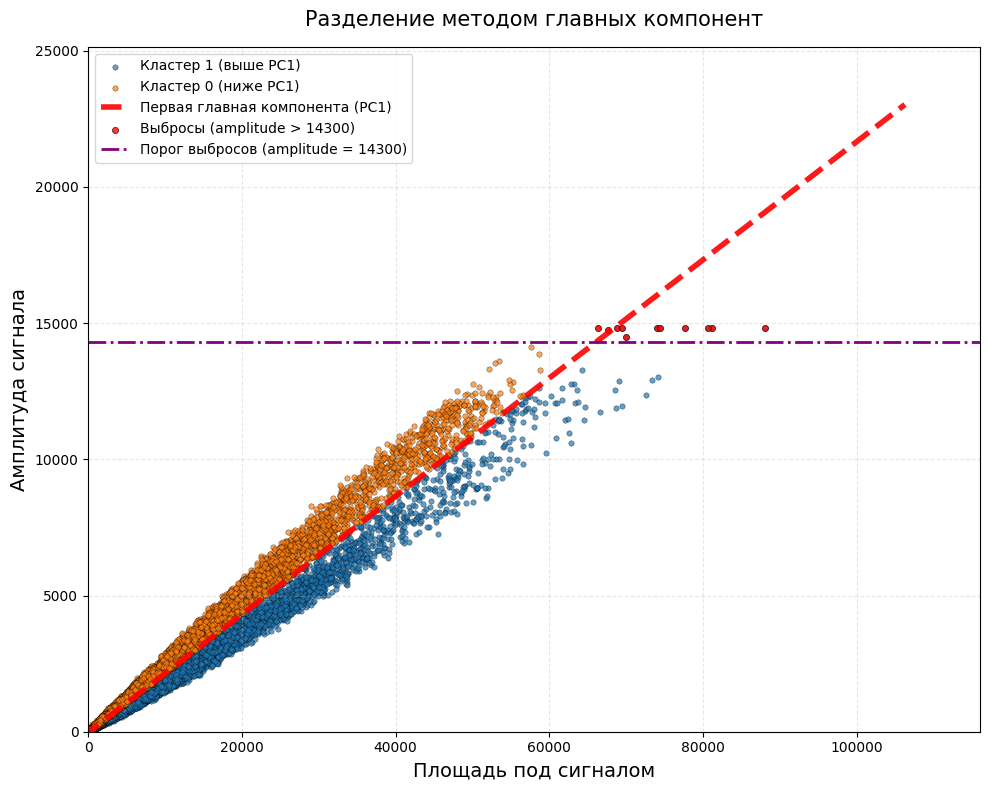

In [908]:
from sklearn.decomposition import PCA

X = dataset[["volume", "amplitude"]].values

pca = PCA(n_components=1)
X_proj = pca.fit_transform(X)

center = X.mean(axis=0)
pc1 = pca.components_[0]

t = np.linspace(-1e5, 1e5, 2)
line = center + t[:, None] * pc1
x_line, y_line = line[:, 0], line[:, 1]

vectors = X - center
cross = vectors[:, 0] * pc1[1] - vectors[:, 1] * pc1[0]
above = cross > 0
below = cross < 0

plt.figure(figsize=(10, 8))

plt.scatter(X[above, 0], X[above, 1], c="tab:blue",  s=15, alpha=0.7,
            edgecolors="black", linewidths=0.3, label="Кластер 1 (выше PC1)")
plt.scatter(X[below, 0], X[below, 1], c="tab:orange", s=15, alpha=0.7,
            edgecolors="black", linewidths=0.3, label="Кластер 0 (ниже PC1)")

plt.plot(x_line, y_line, "r--", linewidth=4, alpha=0.9, label="Первая главная компонента (PC1)")

amp_thr = 14300
outliers = dataset["amplitude"] > amp_thr
if outliers.any():
    plt.scatter(dataset.loc[outliers, "volume"], dataset.loc[outliers, "amplitude"],
                c="red", s=20, alpha=0.8, edgecolors="black", linewidths=0.5,
                label="Выбросы (amplitude > 14300)")

plt.axhline(y=amp_thr, color="purple", linestyle="-.", linewidth=2,
            label="Порог выбросов (amplitude = 14300)")

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда сигнала", fontsize=14)
plt.title("Разделение методом главных компонент", fontsize=15, pad=15)
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

labels = np.where(outliers, 2, np.where(above, 1, 0))
labels = np.where(labels == 0, 1, np.where(labels == 1, 0, 2))
save(labels)

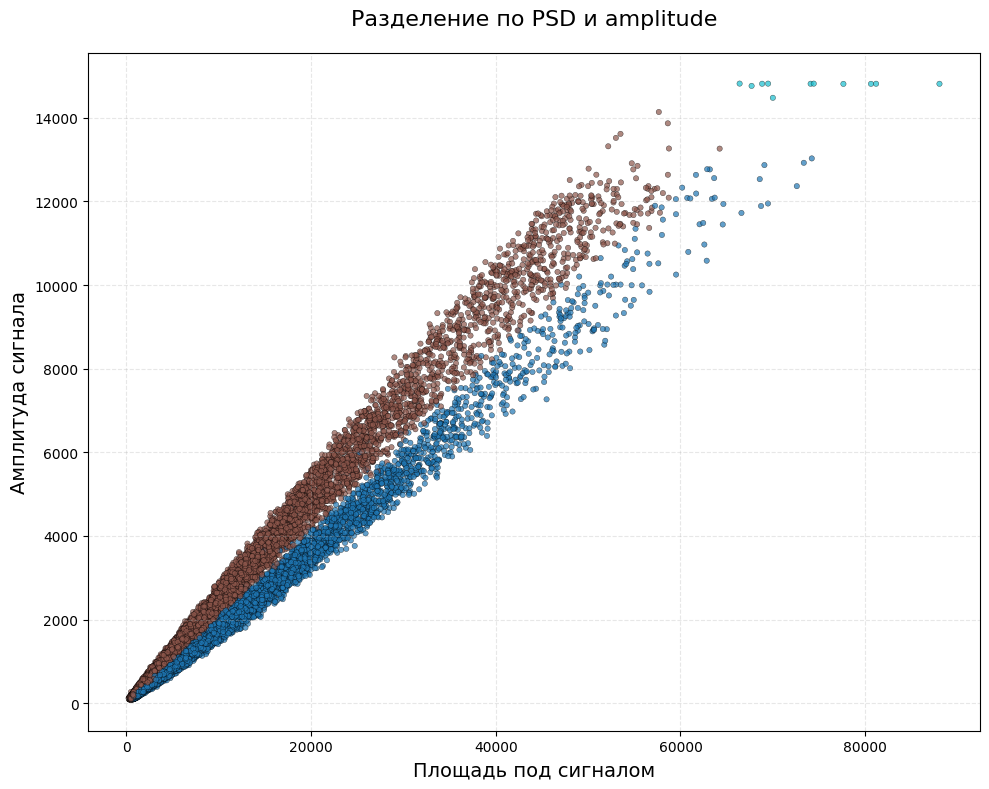

In [909]:
labels = (dataset["psd"] < 0.37).astype(int)

labels[dataset["amplitude"] > 14300] = 2

plt.figure(figsize=(10, 8))

scatterplot = plt.scatter(volumes, amplitudes,
                          c=labels,
                          s=15,
                          alpha=0.7,
                          cmap="tab10",
                          edgecolors="black",
                          linewidths=0.3)

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда сигнала", fontsize=14)
plt.title("Разделение по PSD и amplitude",
          fontsize=16, pad=20)

plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

save(labels)

In [ ]:
from sklearn.preprocessing import StandardScaler

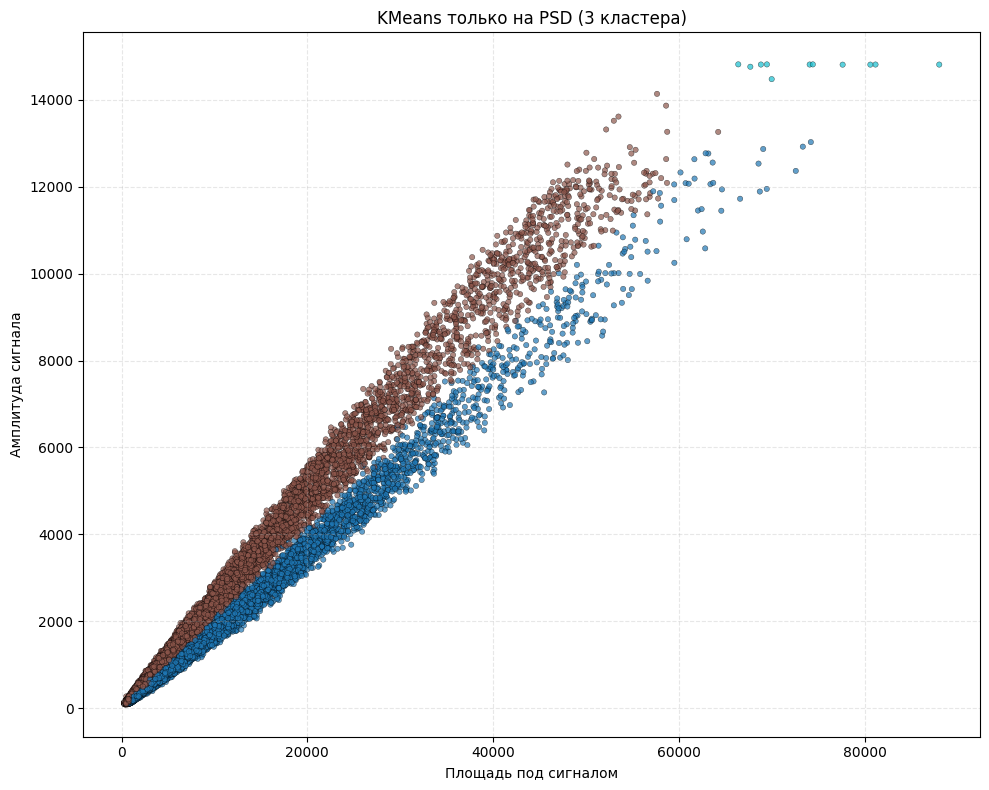

In [917]:
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_psd = scaler.fit_transform(psd_values[~np.isnan(psd_values)].reshape(-1, 1))

kmeans_psd = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_psd_labels_full = np.full(len(psd_values), -1)
valid_indices = ~np.isnan(psd_values)

labels[valid_indices] = 1 - kmeans_psd.fit_predict(X_psd)

labels[amplitudes > 14300] = 2

plt.figure(figsize=(10, 8))
plt.scatter(volumes, amplitudes,
            c=labels,
            s=15,
            alpha=0.7,
            cmap="tab10",
            edgecolors="black",
            linewidths=0.3)
plt.xlabel("Площадь под сигналом")
plt.ylabel("Амплитуда сигнала")
plt.title("KMeans только на PSD (3 кластера)")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


save(labels)

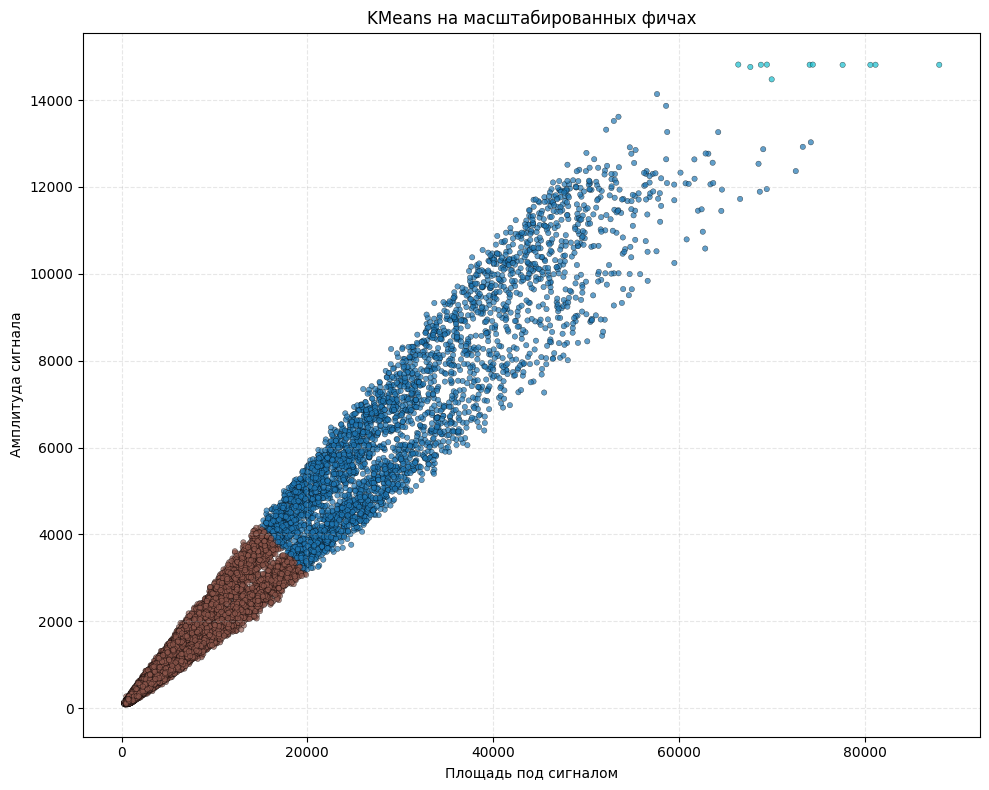

In [918]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

scaler = StandardScaler()
X = dataset[["volume", "amplitude", "psd"]].values
X_scaled = scaler.fit_transform(X)

clusters = kmeans.fit_predict(X_scaled)

labels = np.full(len(dataset), -1)
labels[dataset.index] = 1 - clusters
labels[amplitudes > 14300] = 2

plt.figure(figsize=(10, 8))
plt.scatter(volumes, amplitudes,
            c=labels,
            s=15,
            alpha=0.7,
            cmap="tab10",
            edgecolors="black",
            linewidths=0.3)
plt.xlabel("Площадь под сигналом")
plt.ylabel("Амплитуда сигнала")
plt.title("KMeans на масштабированных фичах")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

#save(labels)

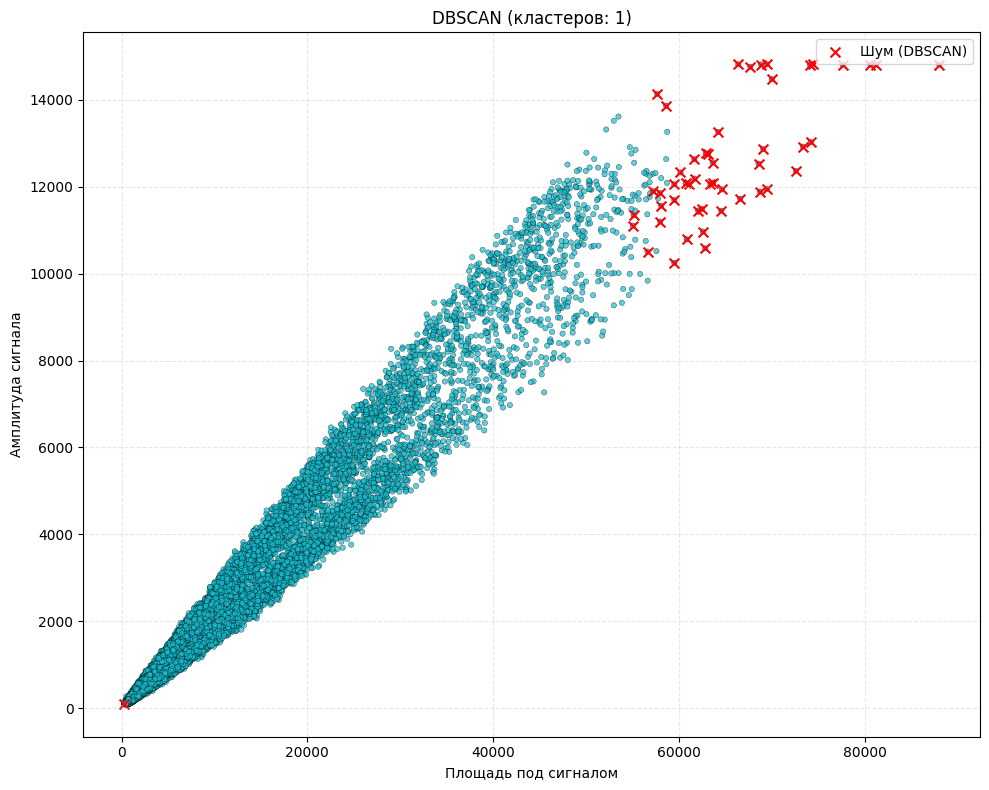

In [919]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=50)
clusters = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(volumes, amplitudes,
            c=clusters,
            s=15,
            alpha=0.7,
            cmap="tab10",
            edgecolors="black",
            linewidths=0.3)

noise_mask = clusters == -1
if np.any(noise_mask):
    plt.scatter(volumes[noise_mask], amplitudes[noise_mask],
                c='red', s=50, marker='x', label='Шум (DBSCAN)')

plt.xlabel("Площадь под сигналом")
plt.ylabel("Амплитуда сигнала")
plt.title(f"DBSCAN (кластеров: {len(np.unique(clusters[clusters != -1]))})")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

labels[dataset.index] = clusters
labels[amplitudes > 14300] = 2